In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
results_folder = r'../example/results/boxplot'
stations_csv_file = r'../example/data/Stations.csv'
precipitations_daily_ts_parquet = r'precipitations_daily_time_series.parquet' 

if not os.path.exists(results_folder):
    os.mkdir(results_folder)


In [3]:
df = pd.read_parquet(precipitations_daily_ts_parquet)
df_stations = pd.read_csv(stations_csv_file)

In [4]:
stations_dict = { x['Id'] : x['Name']  for x in df_stations.to_dict(orient='records')}
df['StationName'] = df['StationId'].apply(lambda x: stations_dict[x])

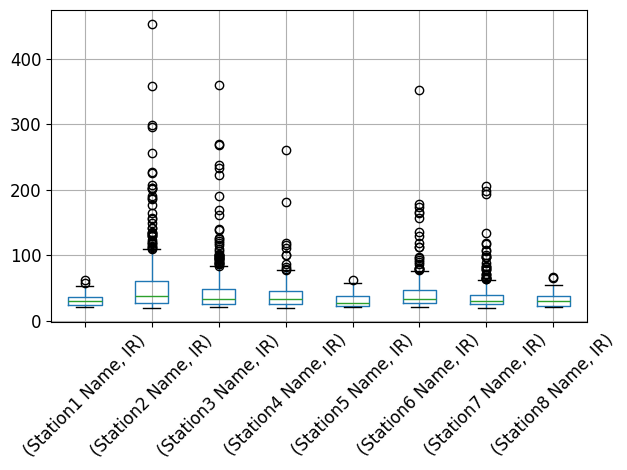

In [5]:
grouped = df[(df['IR']>20) & (df['IR']<600)].groupby('StationName')

boxplot_figure = plt.figure()
boxplot_figure.title = 'BoxPlot'
grouped.boxplot(subplots=False, rot=45, column='IR', fontsize=12, figsize=(10,10))  

plt.tight_layout()
boxplot_figure.savefig(os.path.join(results_folder, "boxplot.png"))


In [61]:
import openturns as ot
import othdrplot as othdr
import openturns.viewer as otv

In [62]:
numberOfPointsForSampling = 500
ot.ResourceMap.SetAsBool("Distribution-MinimumVolumeLevelSetBySampling", True)
ot.ResourceMap.Set(
    "Distribution-MinimumVolumeLevelSetSamplingSize", str(numberOfPointsForSampling)
)

In [63]:
stations = df.groupby(['StationId', 'StationName']).agg(
    min_fecha_hora=('DateTime', 'min'),
    max_fecha_hora=('DateTime', 'max')
).reset_index().values.tolist()

c:\Users\juanort\AppData\Local\Programs\Python\Python311\Lib\site-packages\openturns\viewer.py:210: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  self._fig = plt.figure(**figure_kw)


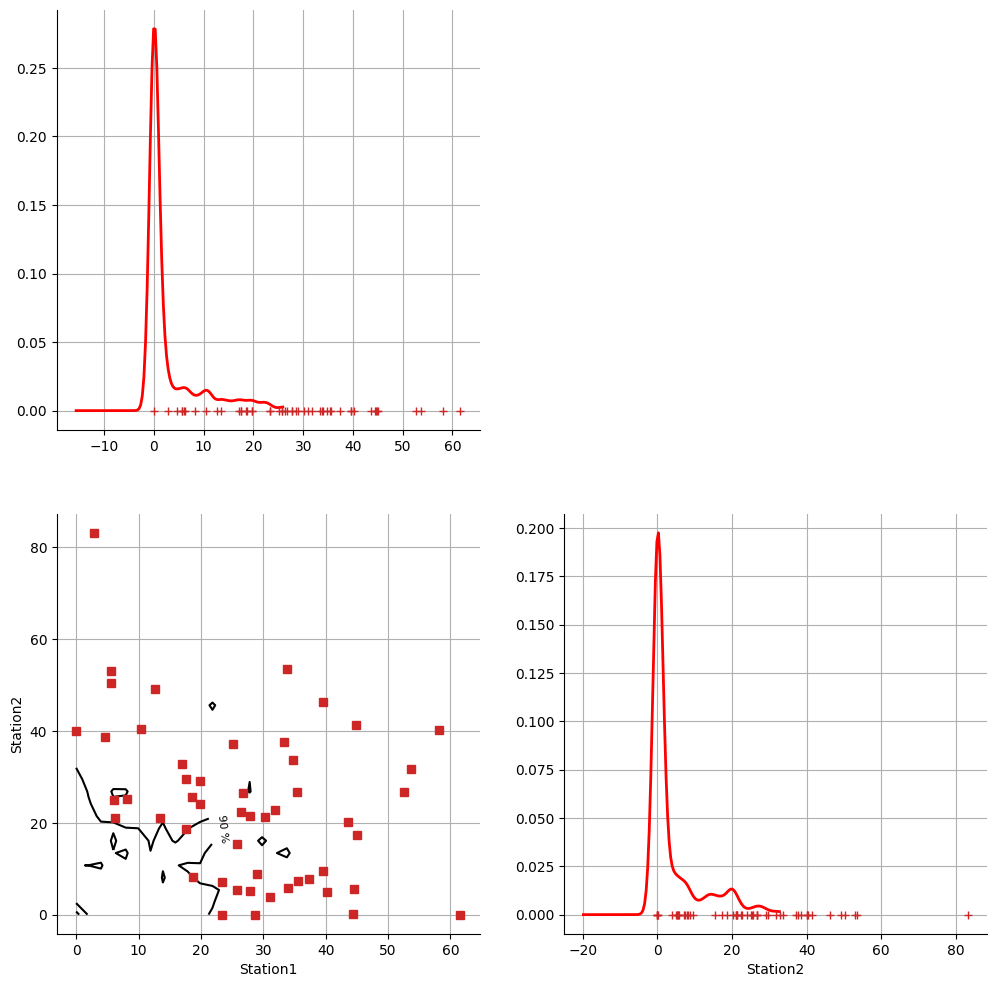

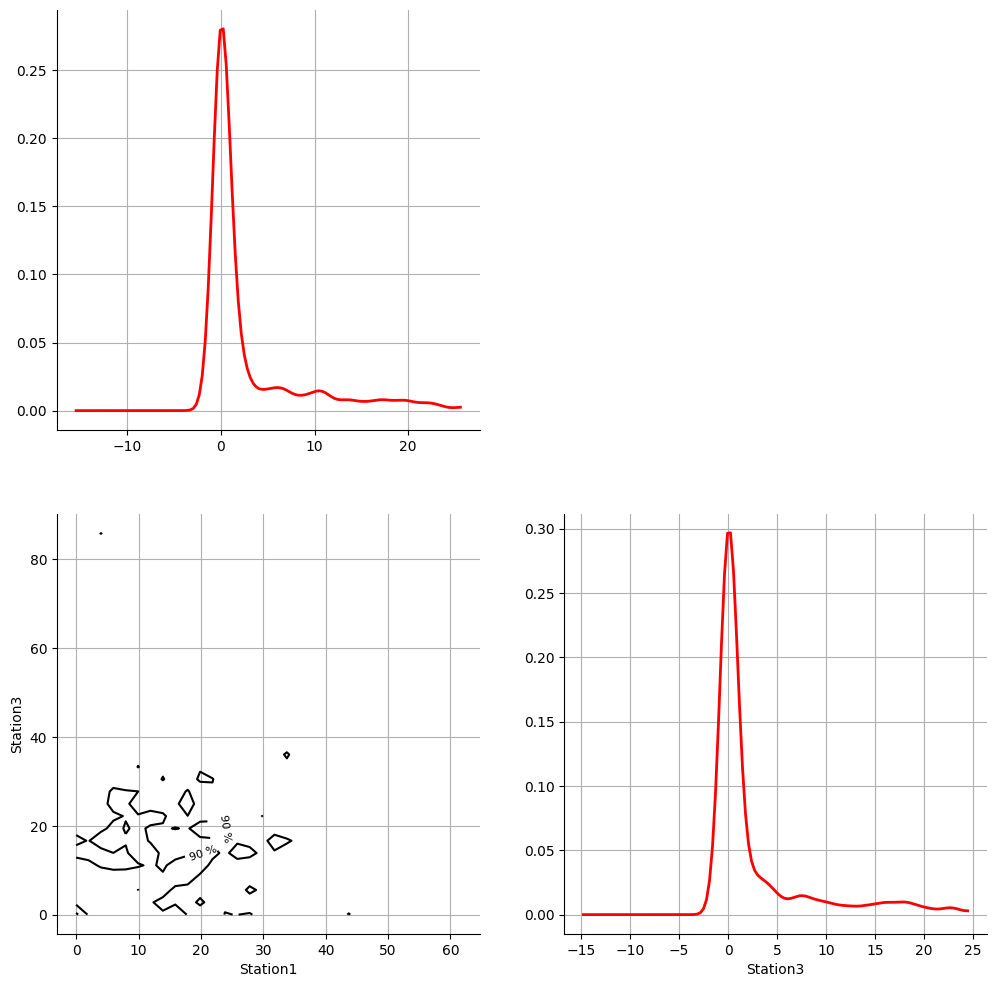

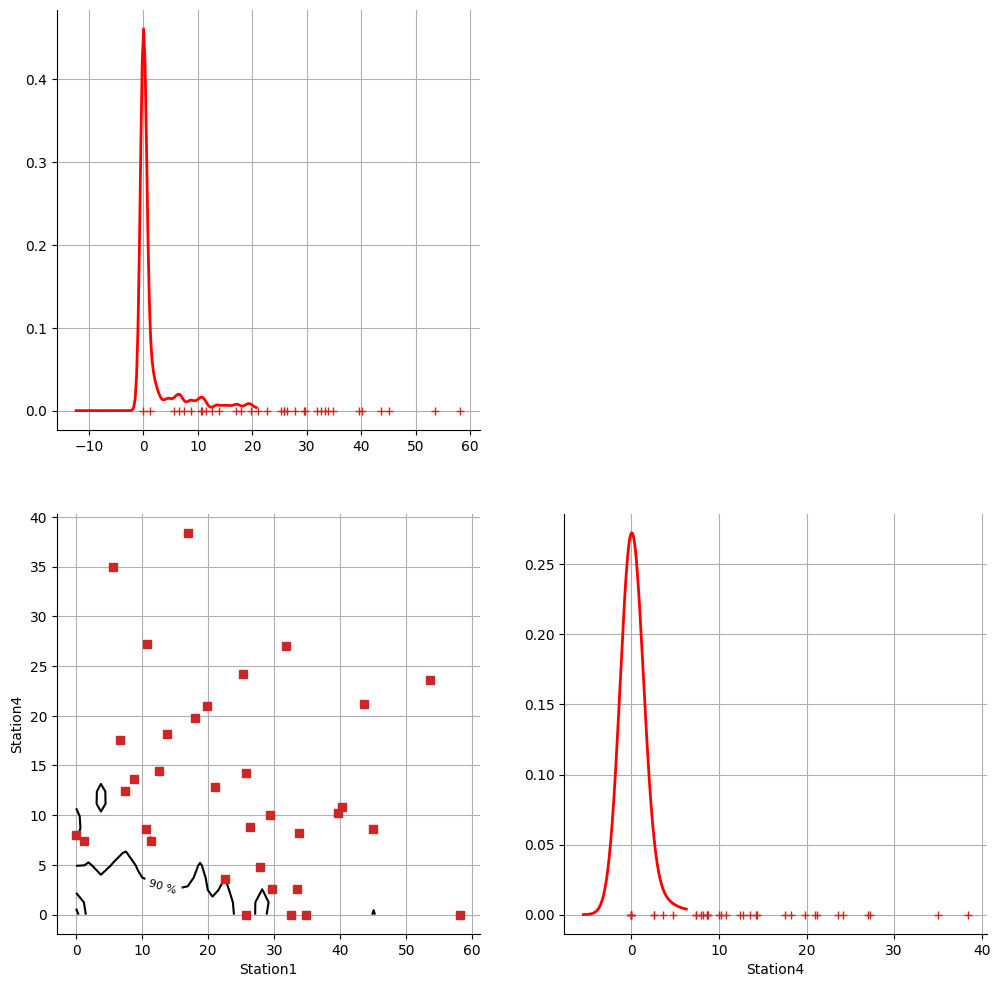

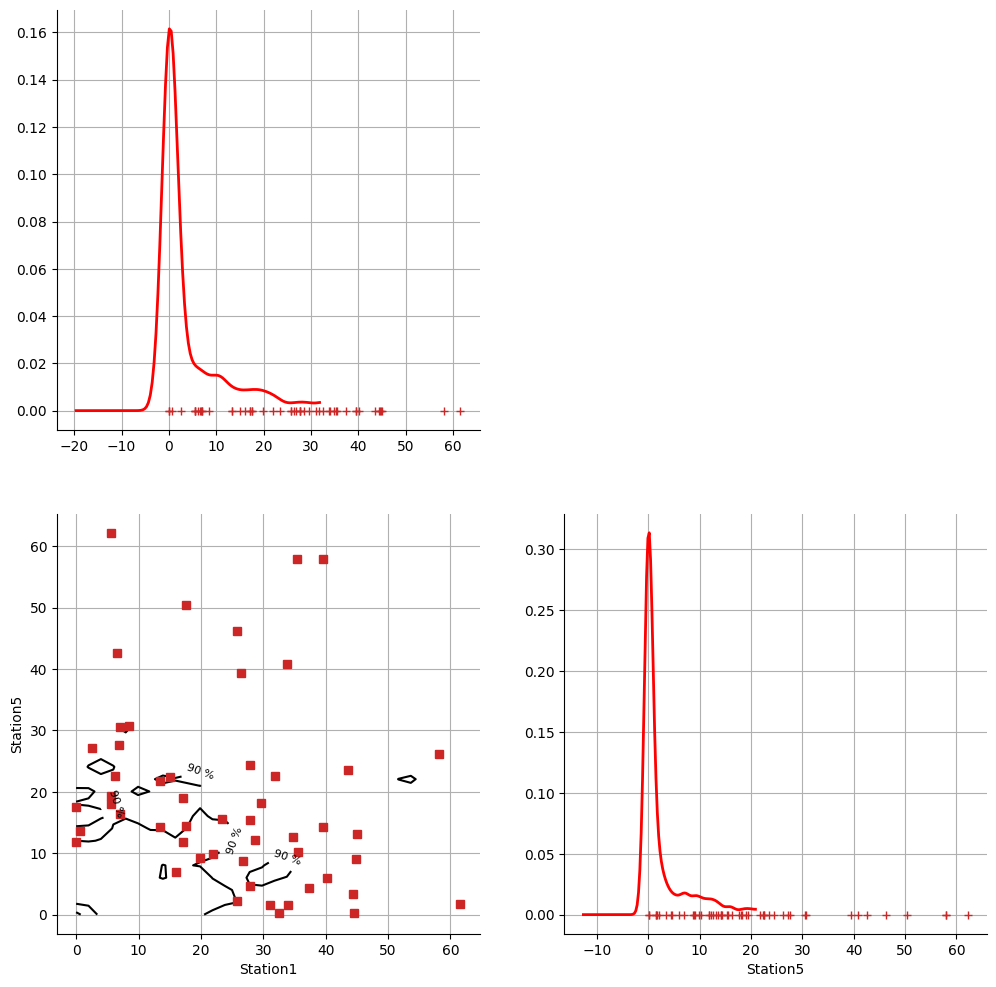

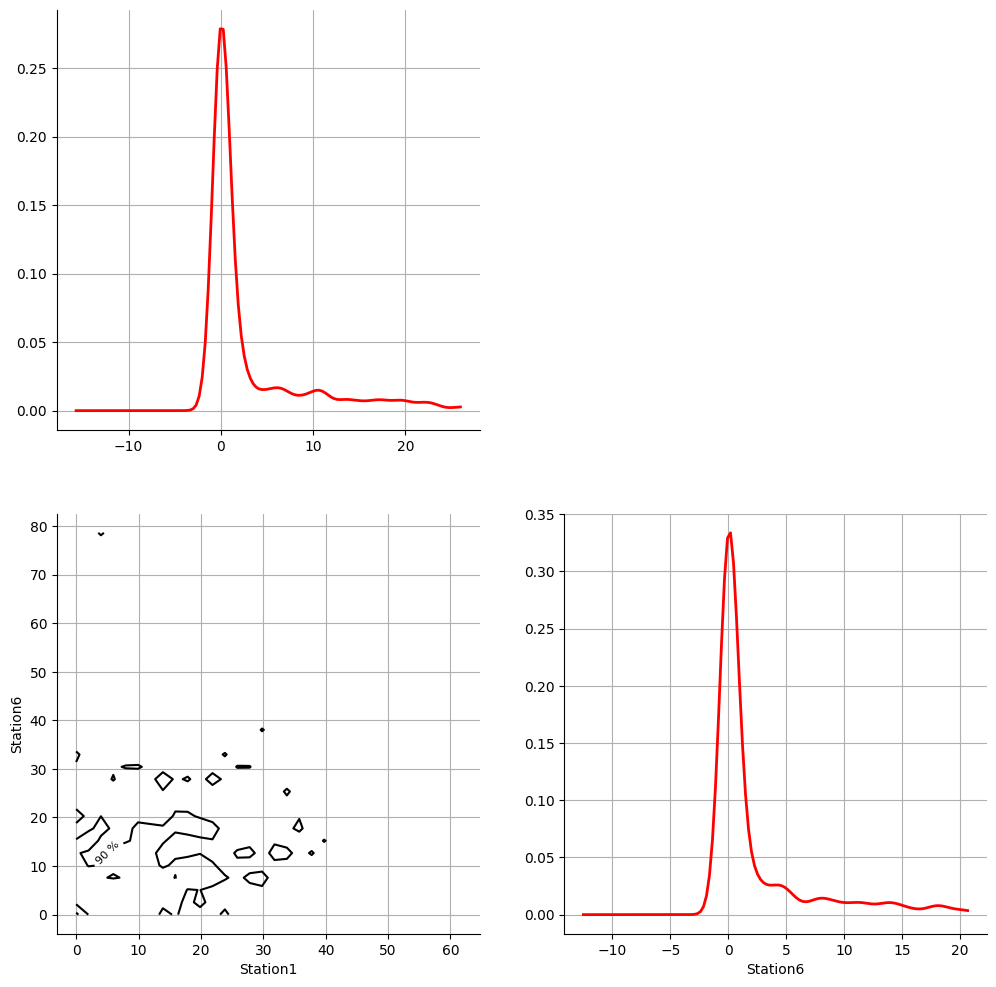

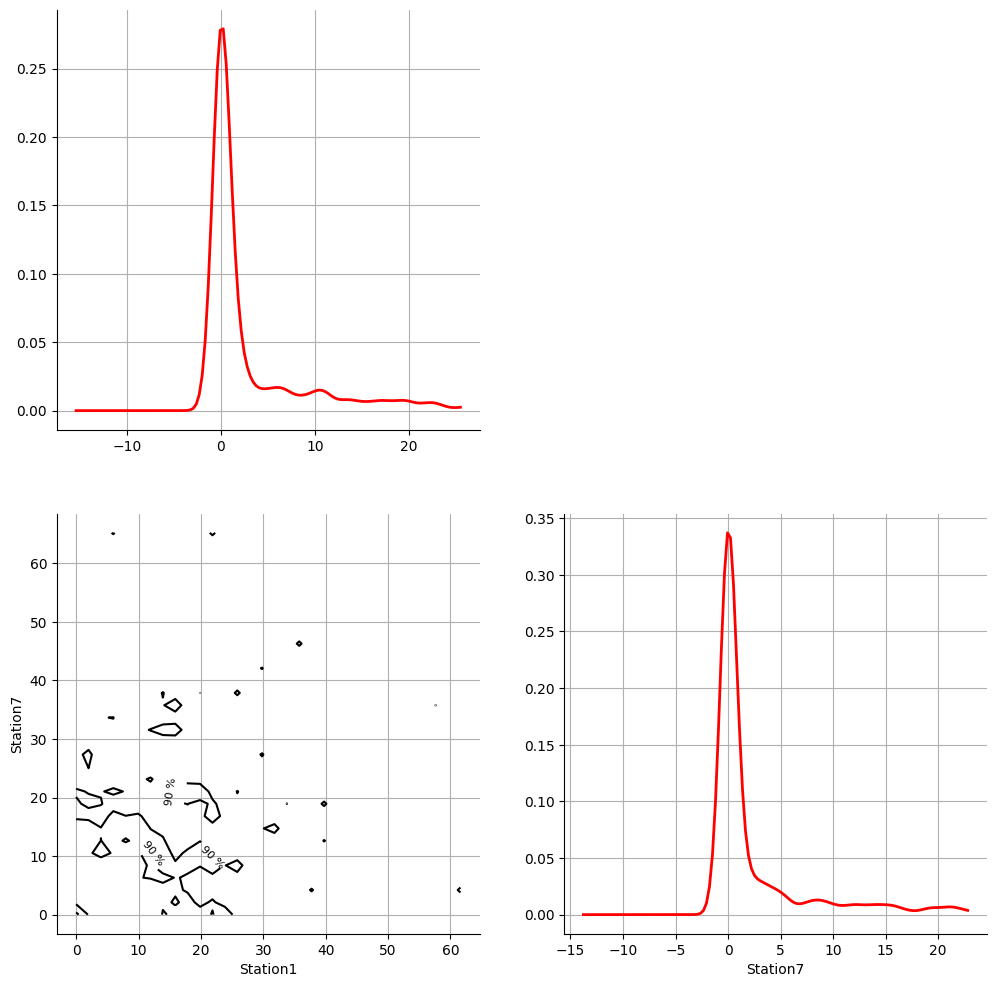

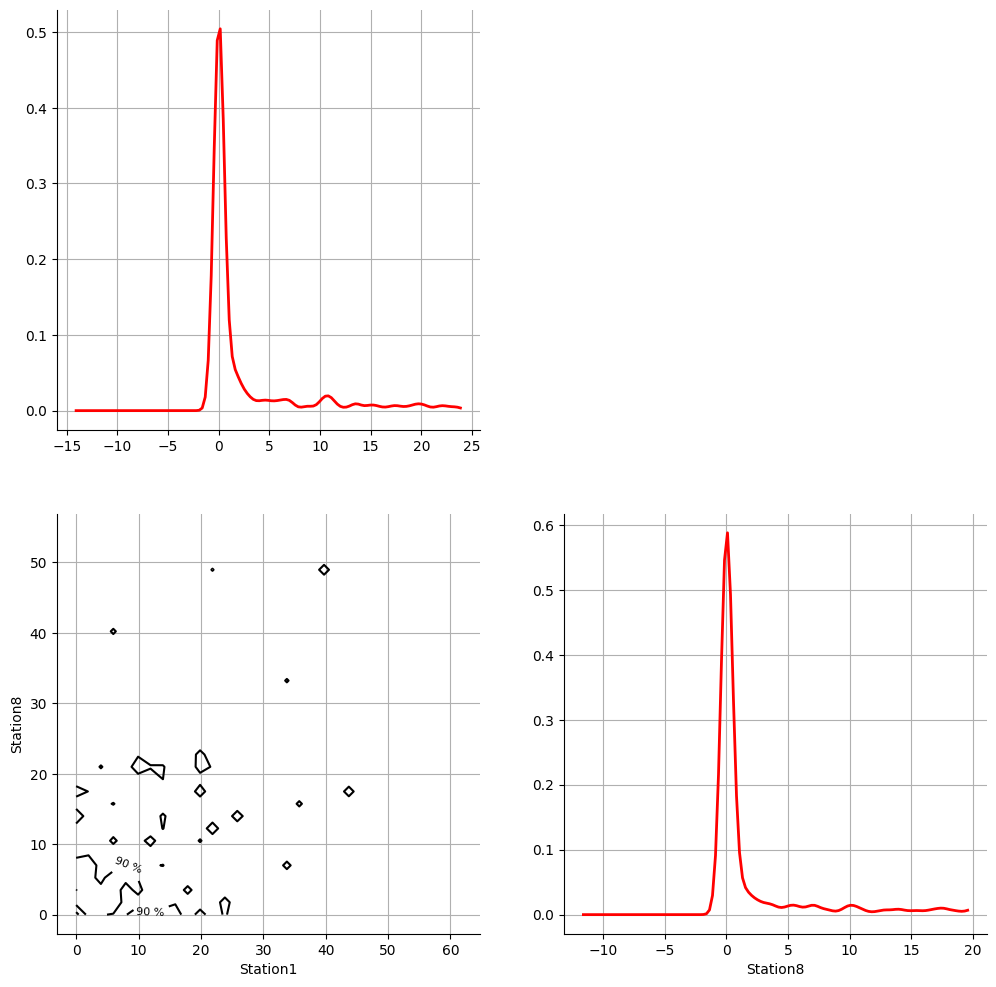

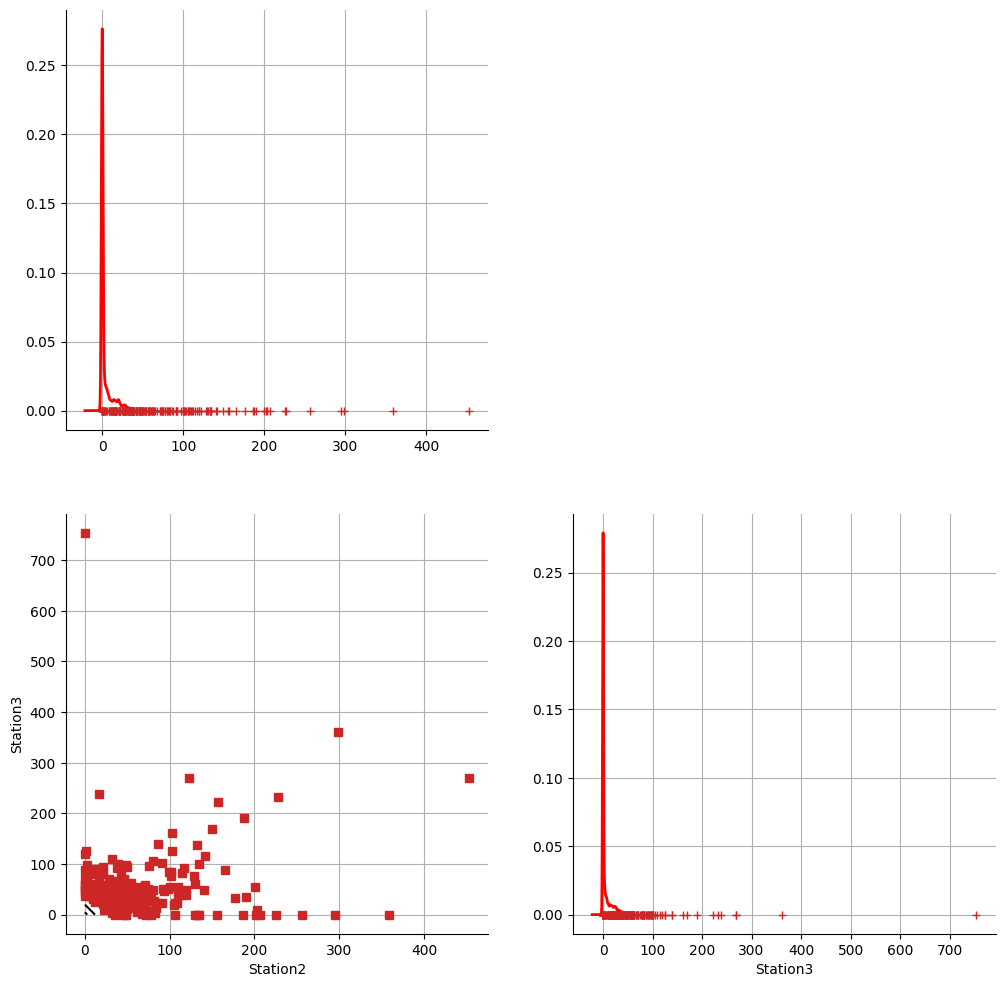

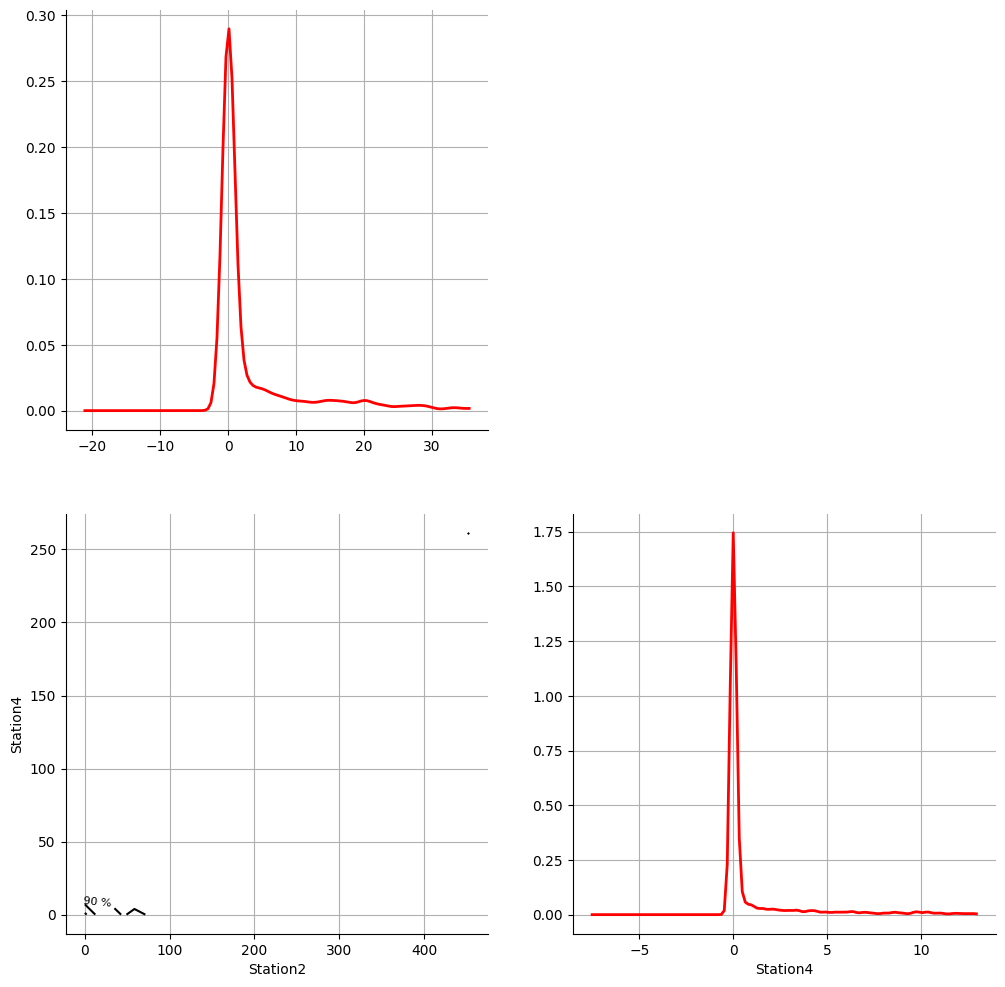

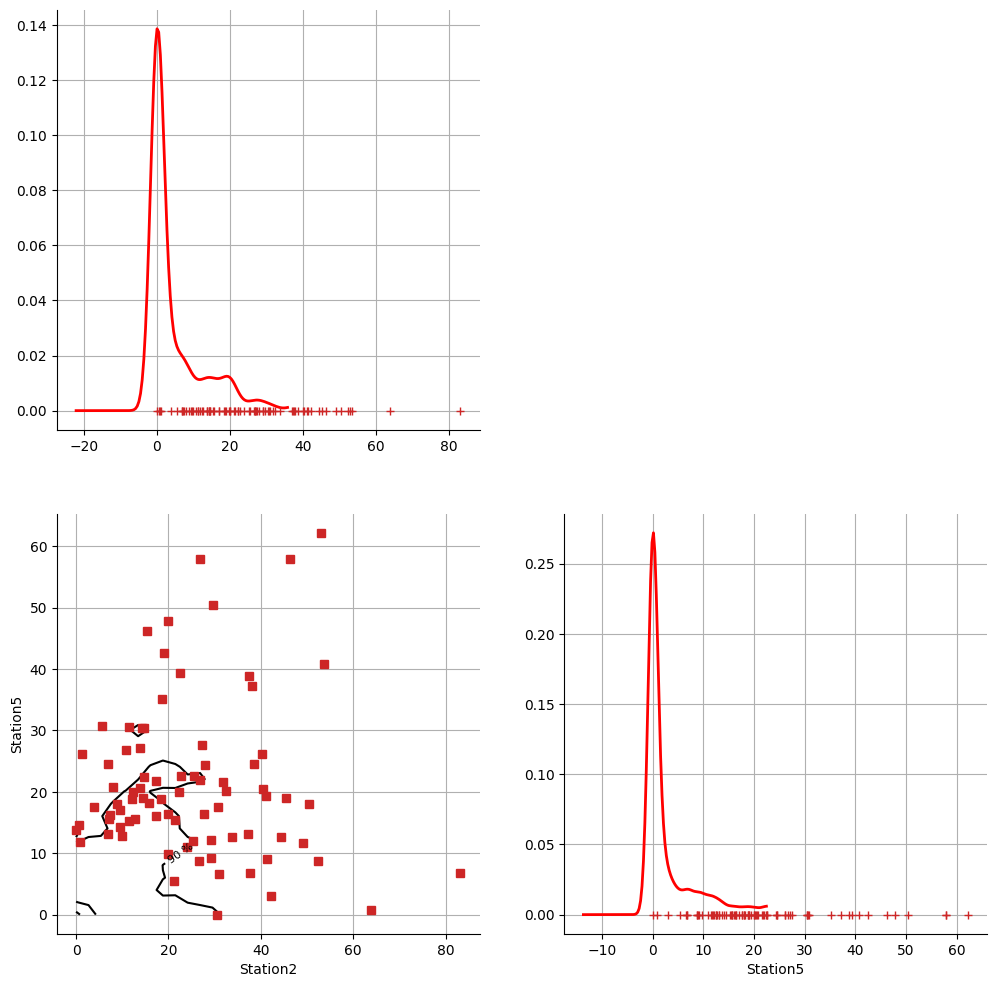

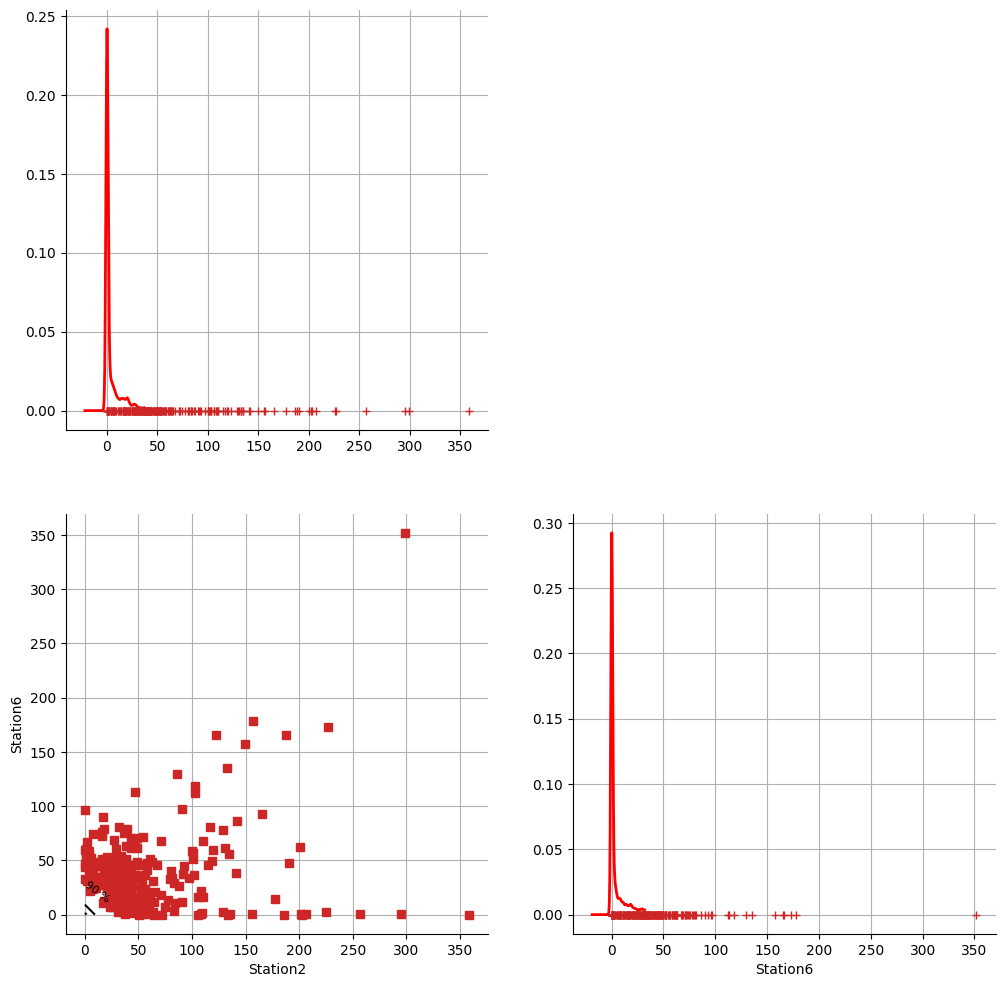

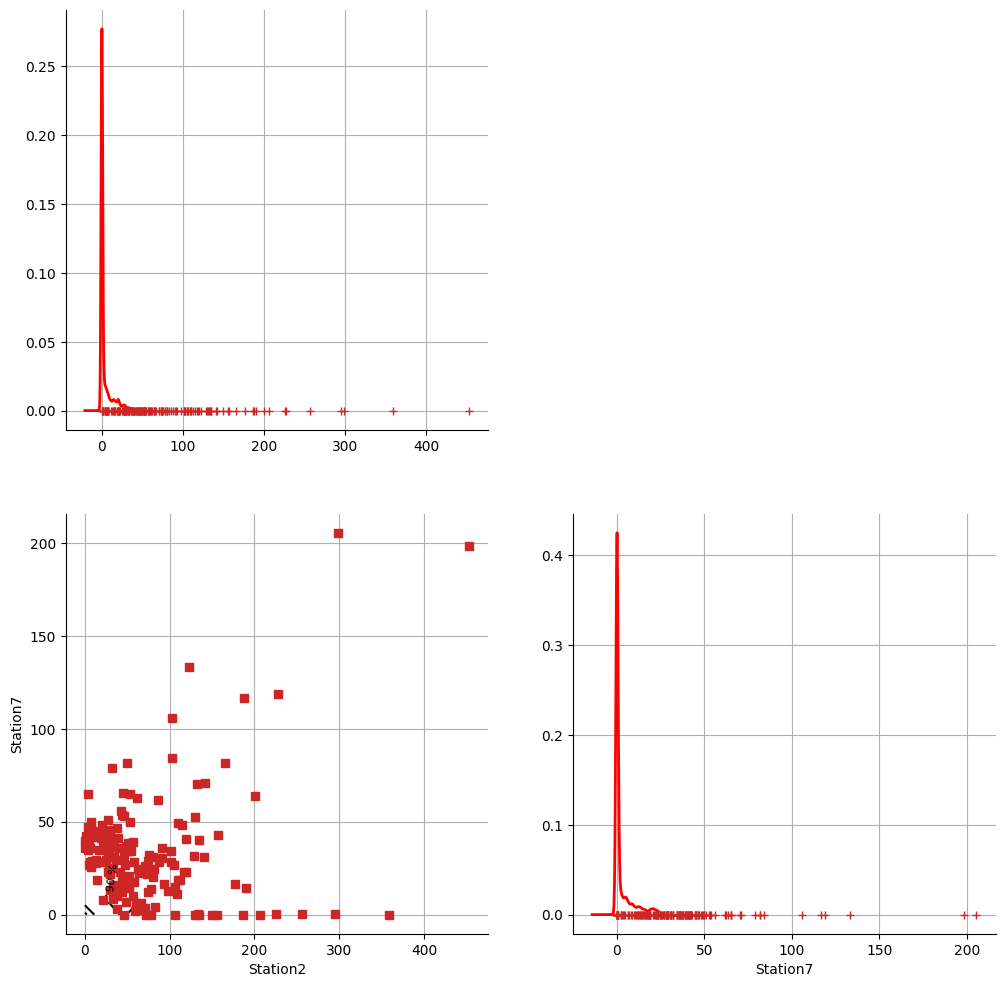

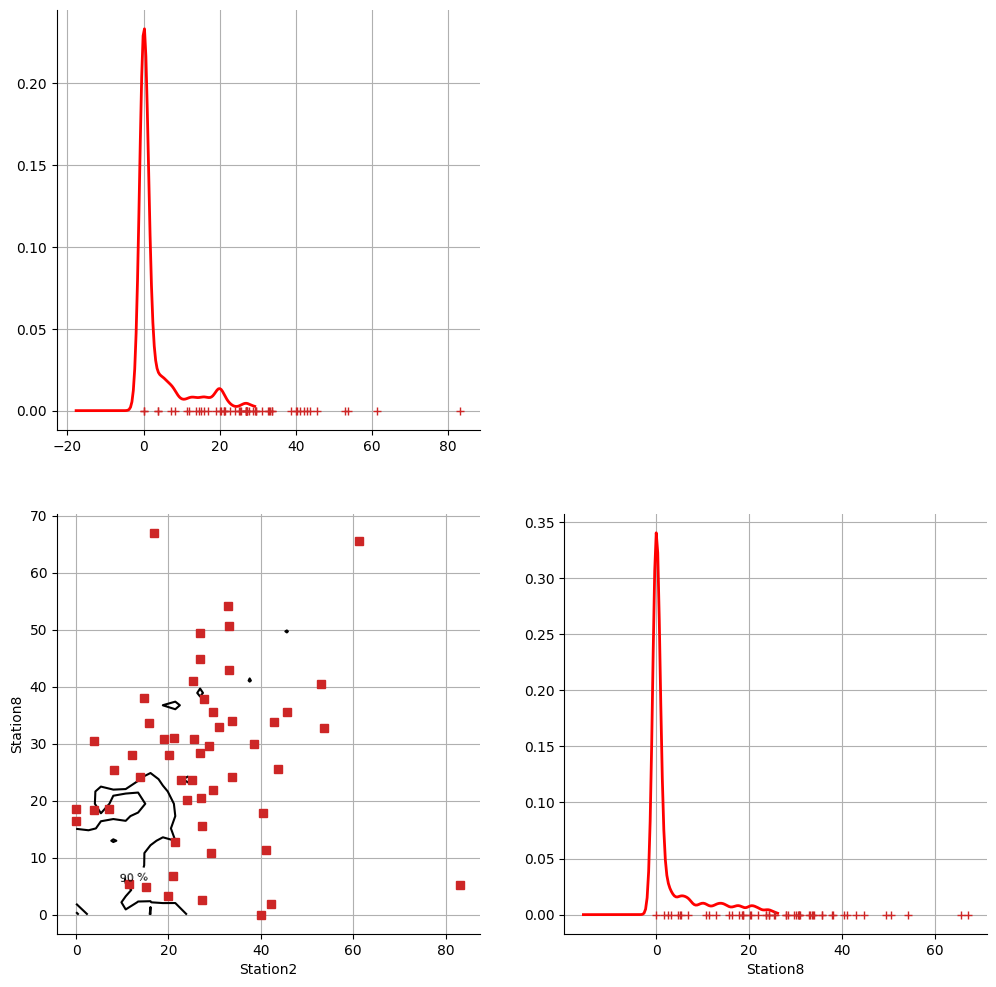

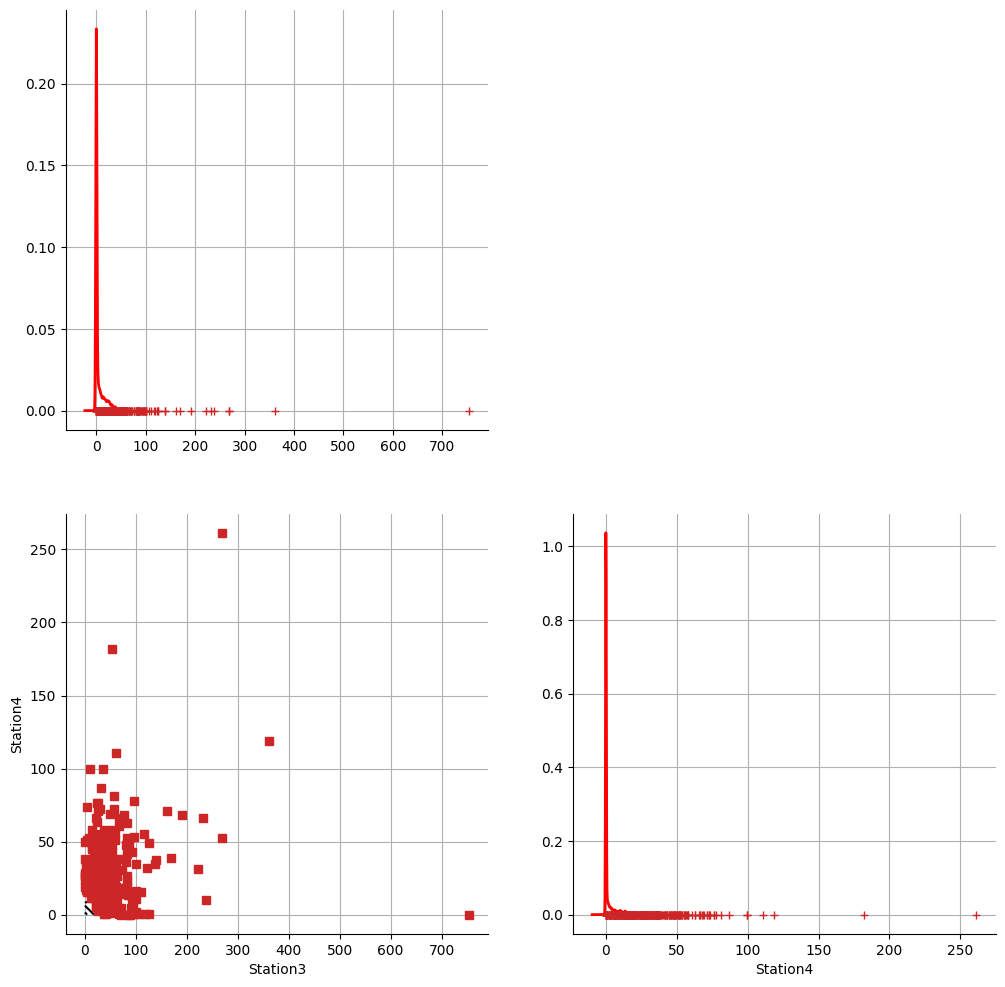

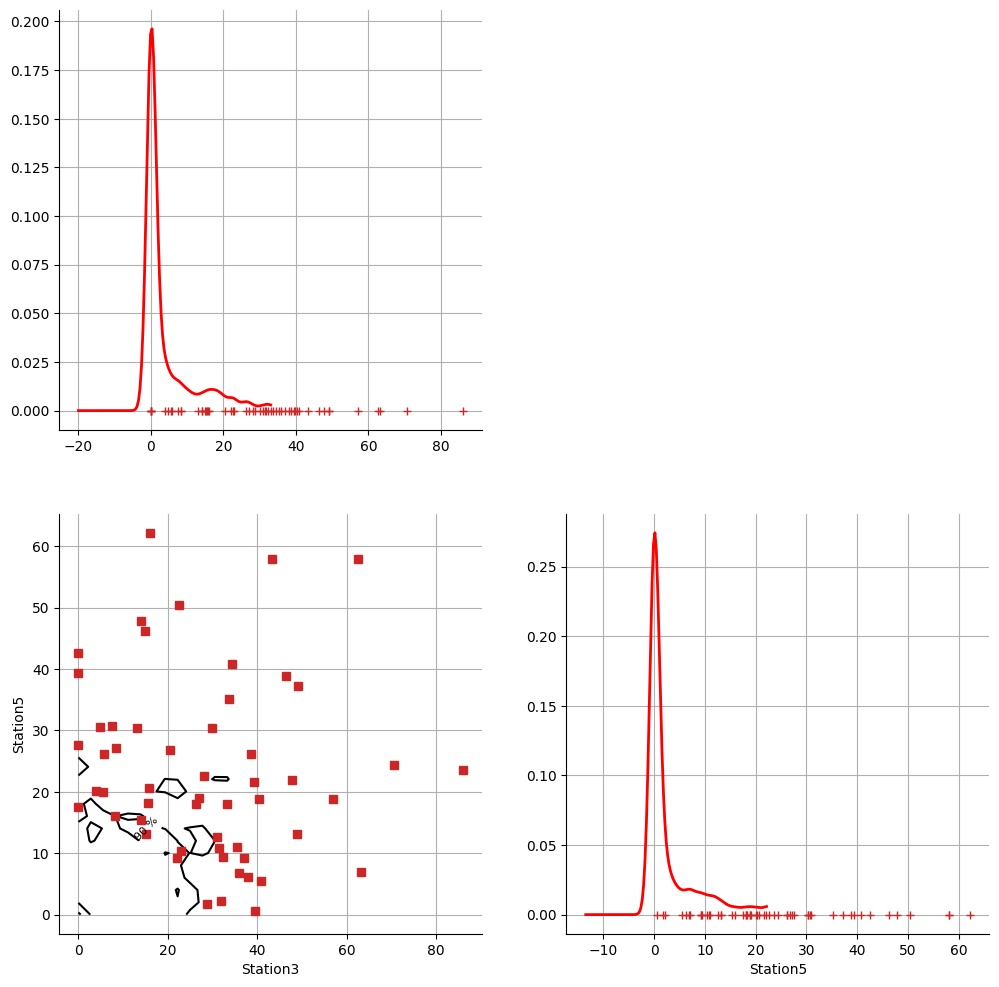

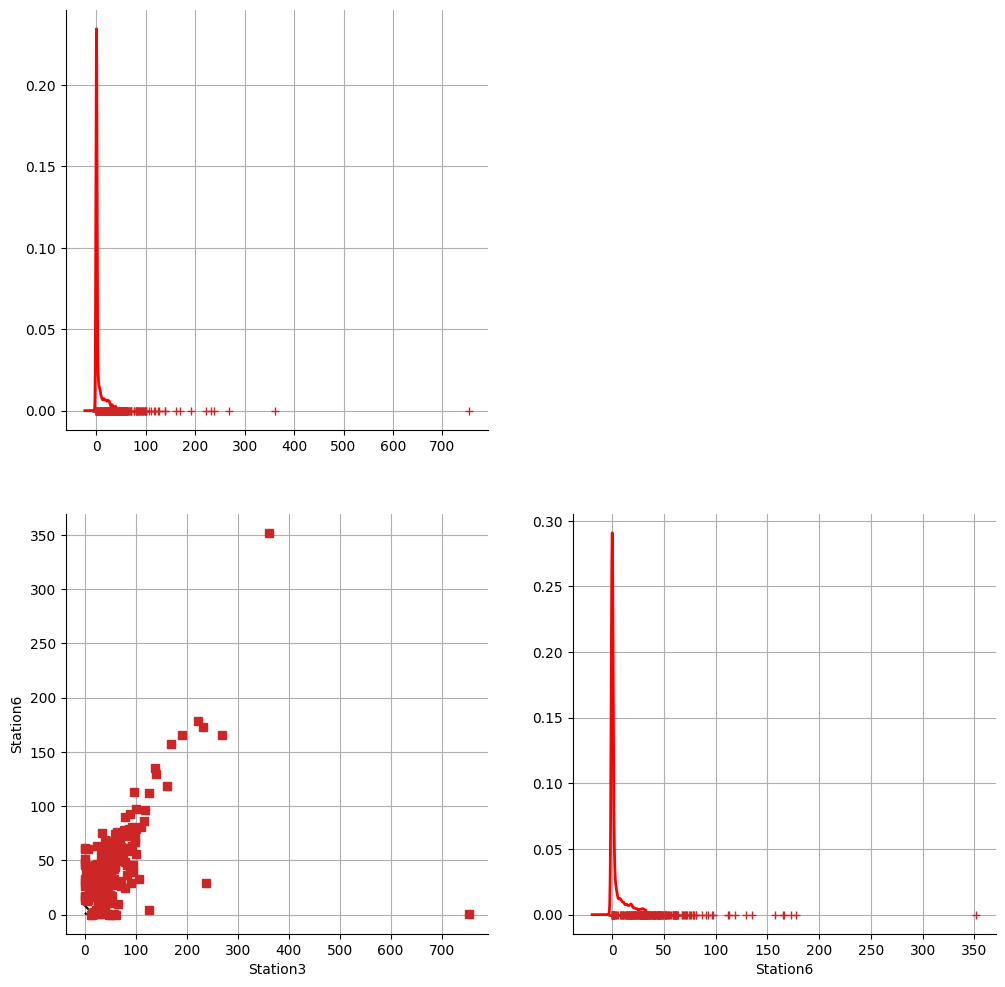

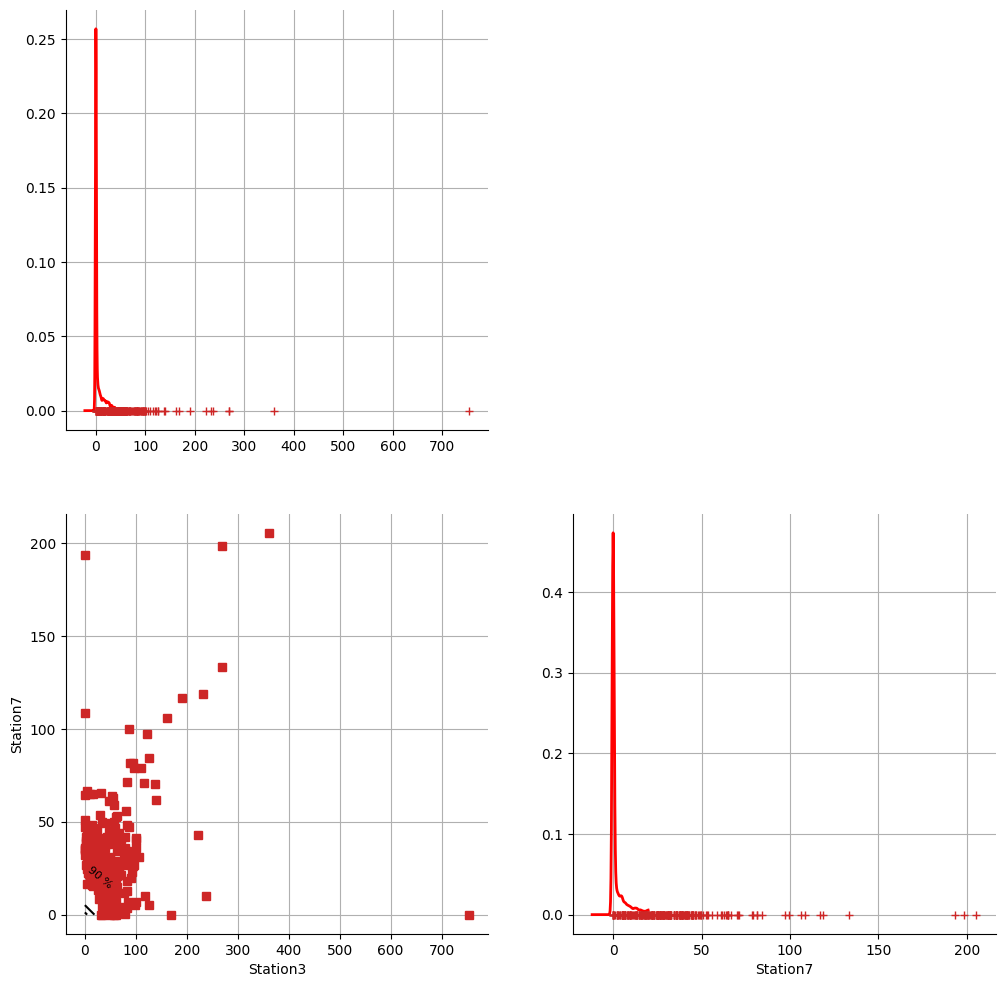

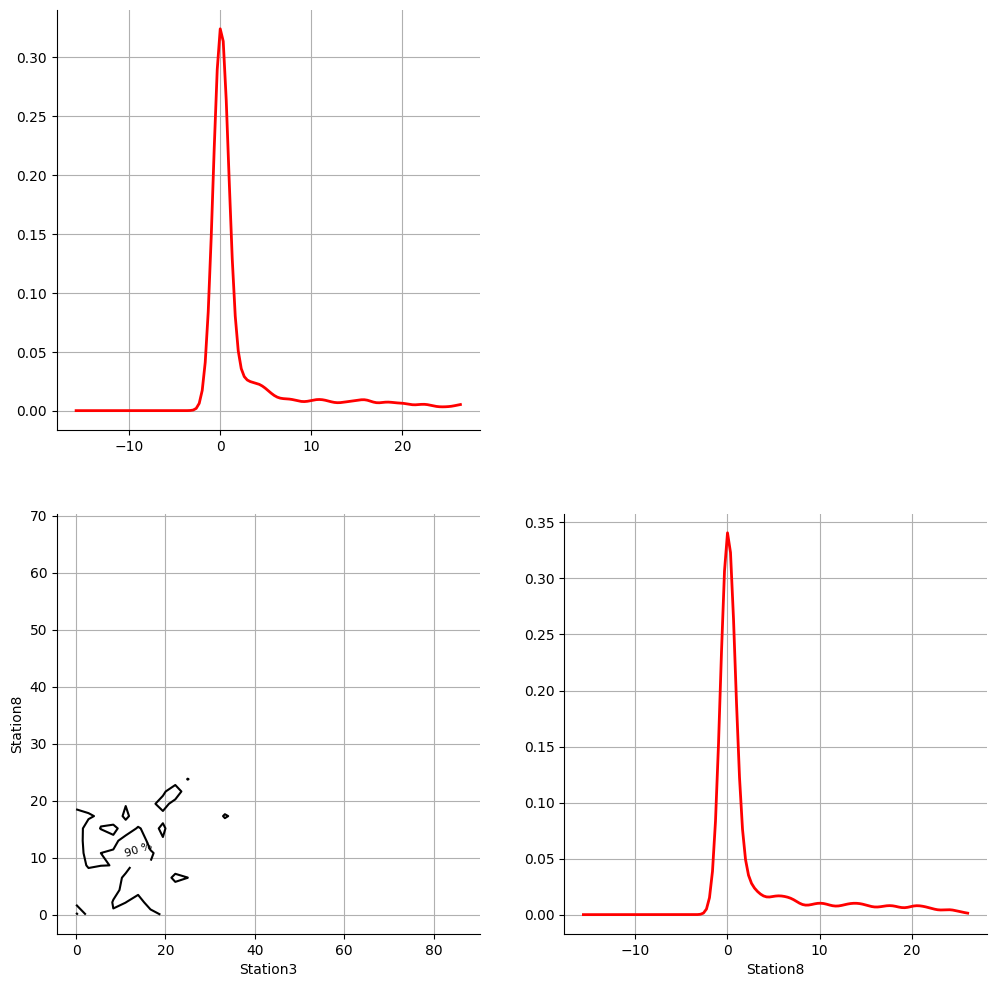

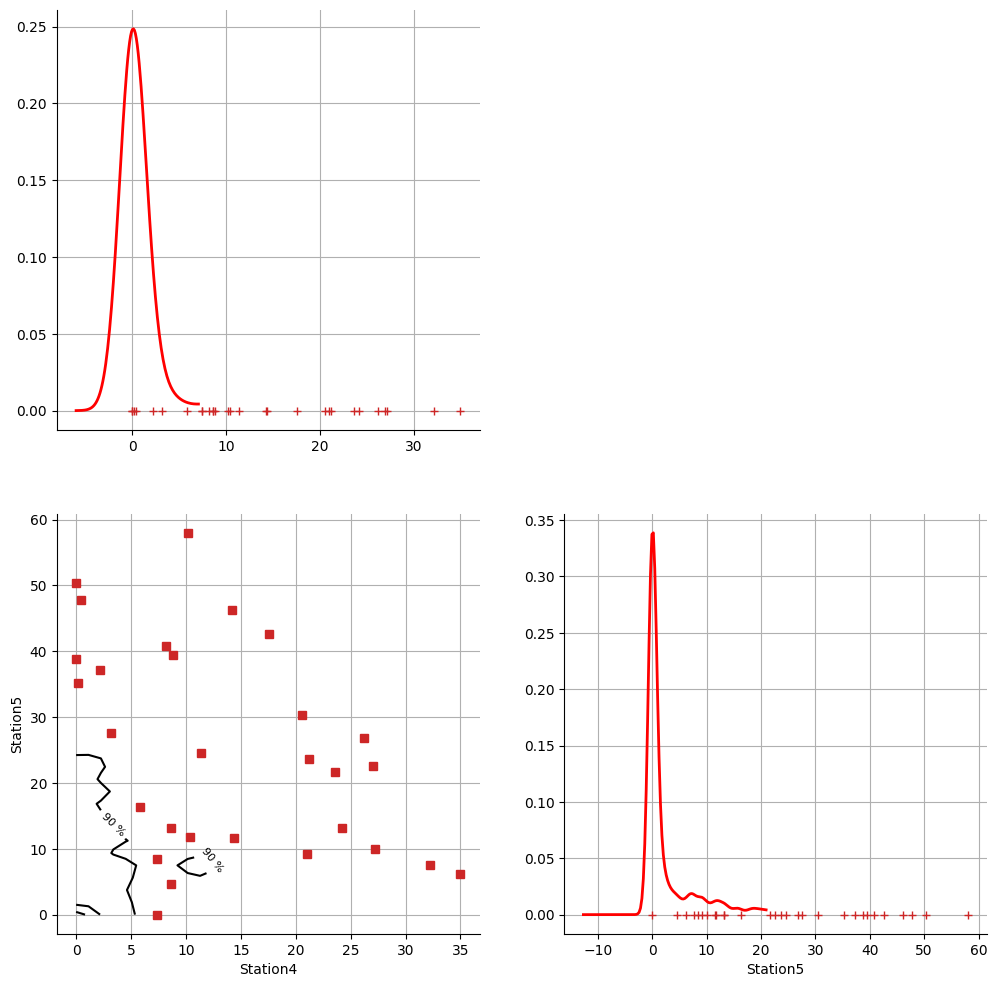

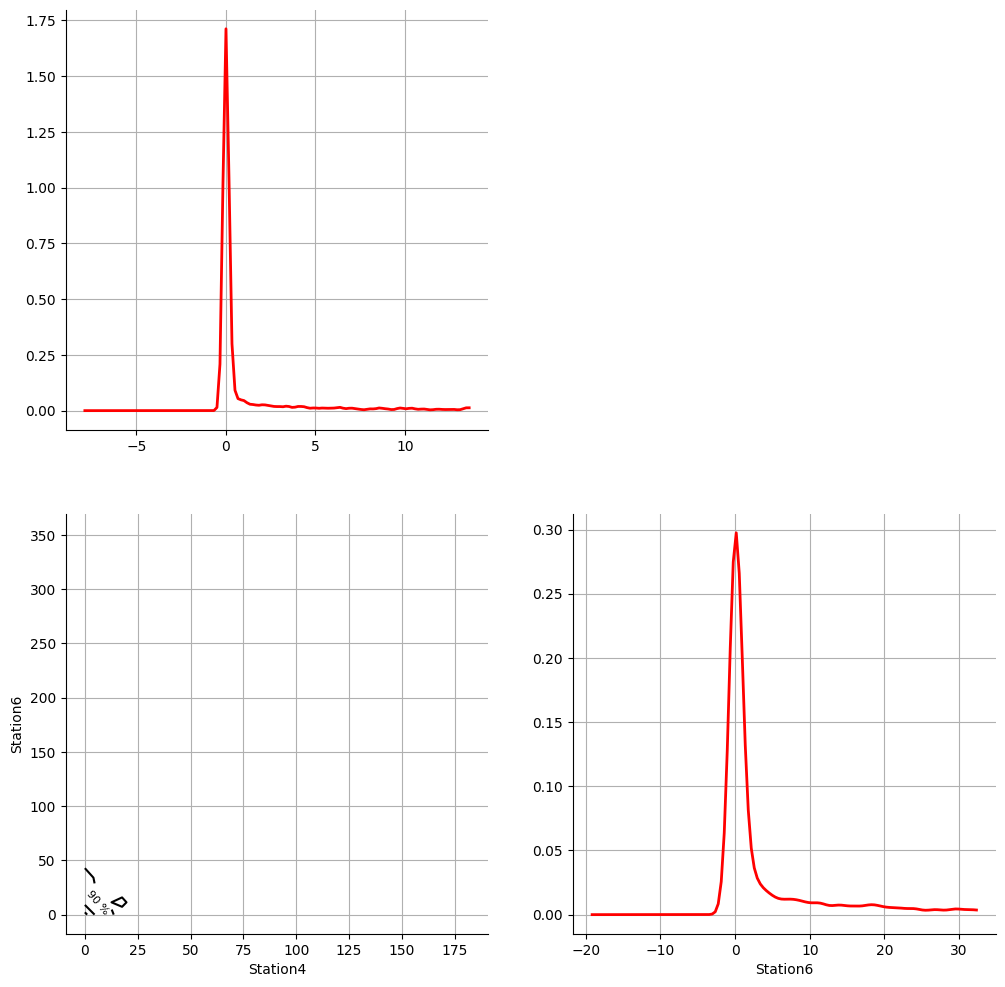

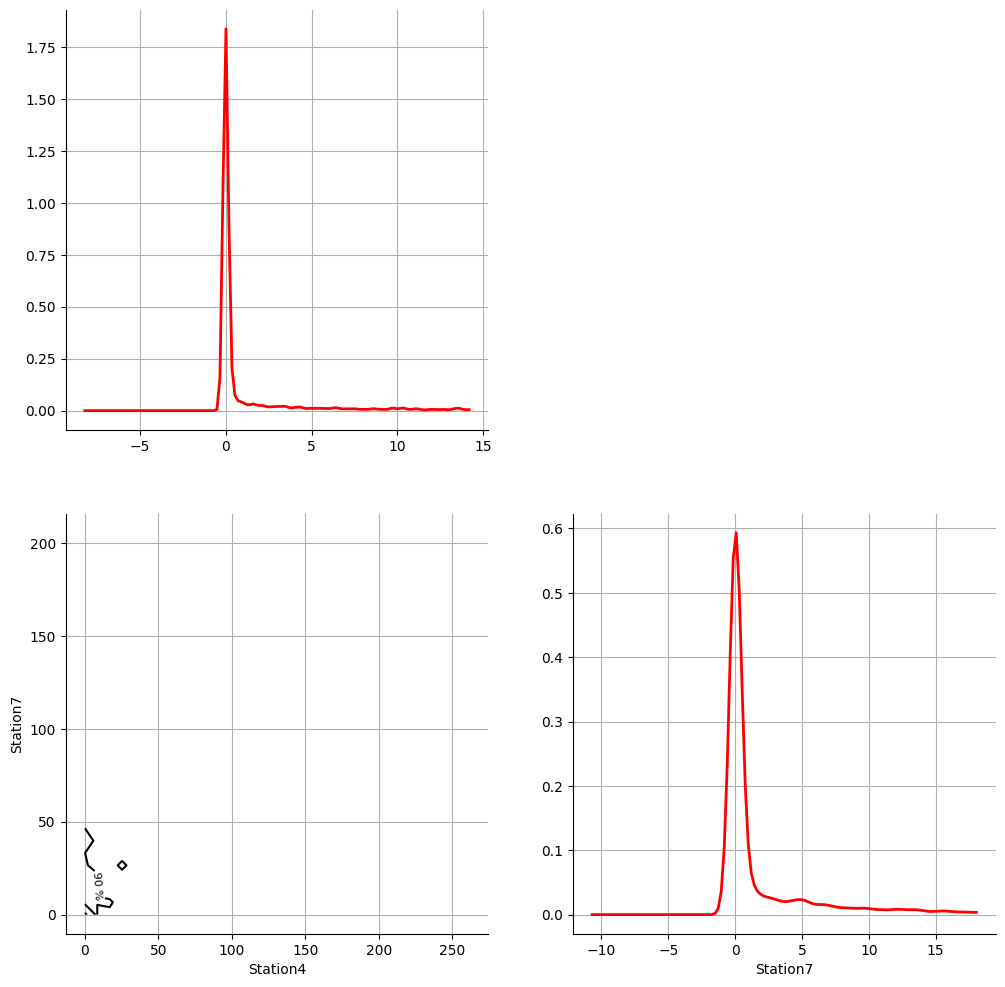

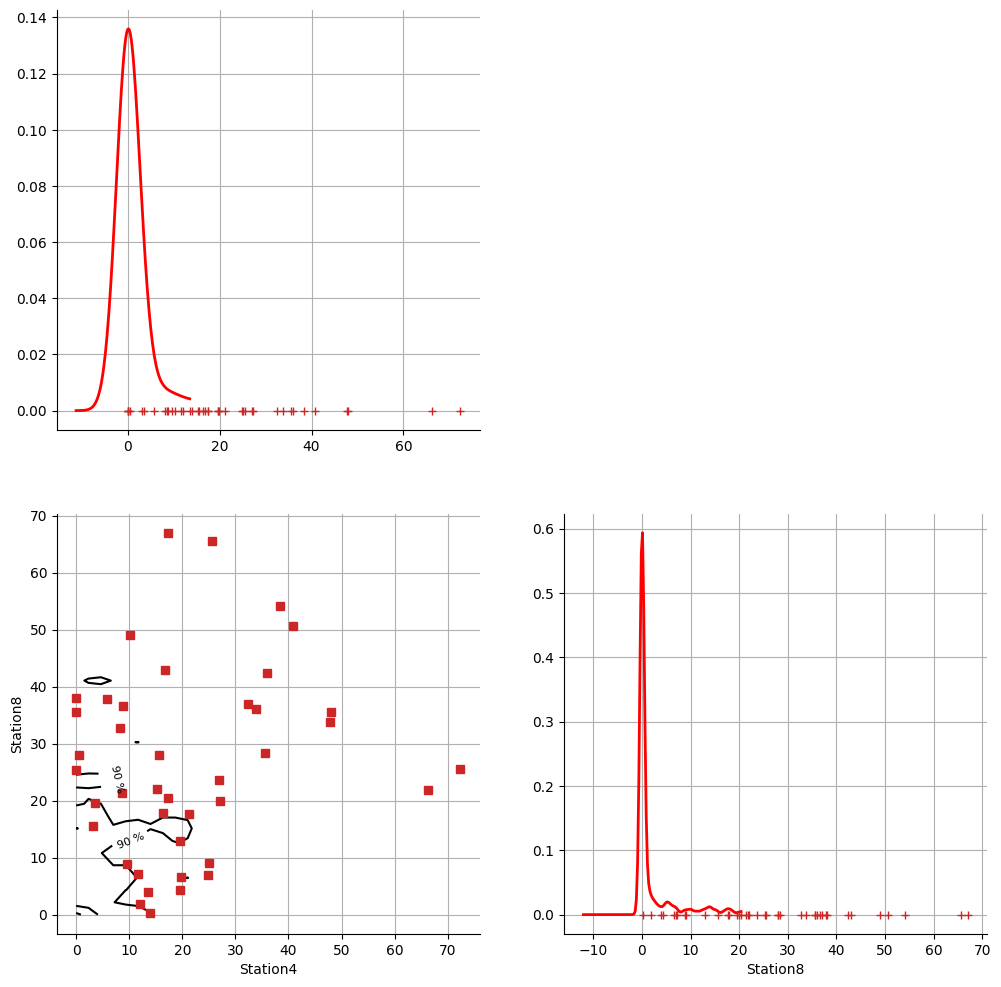

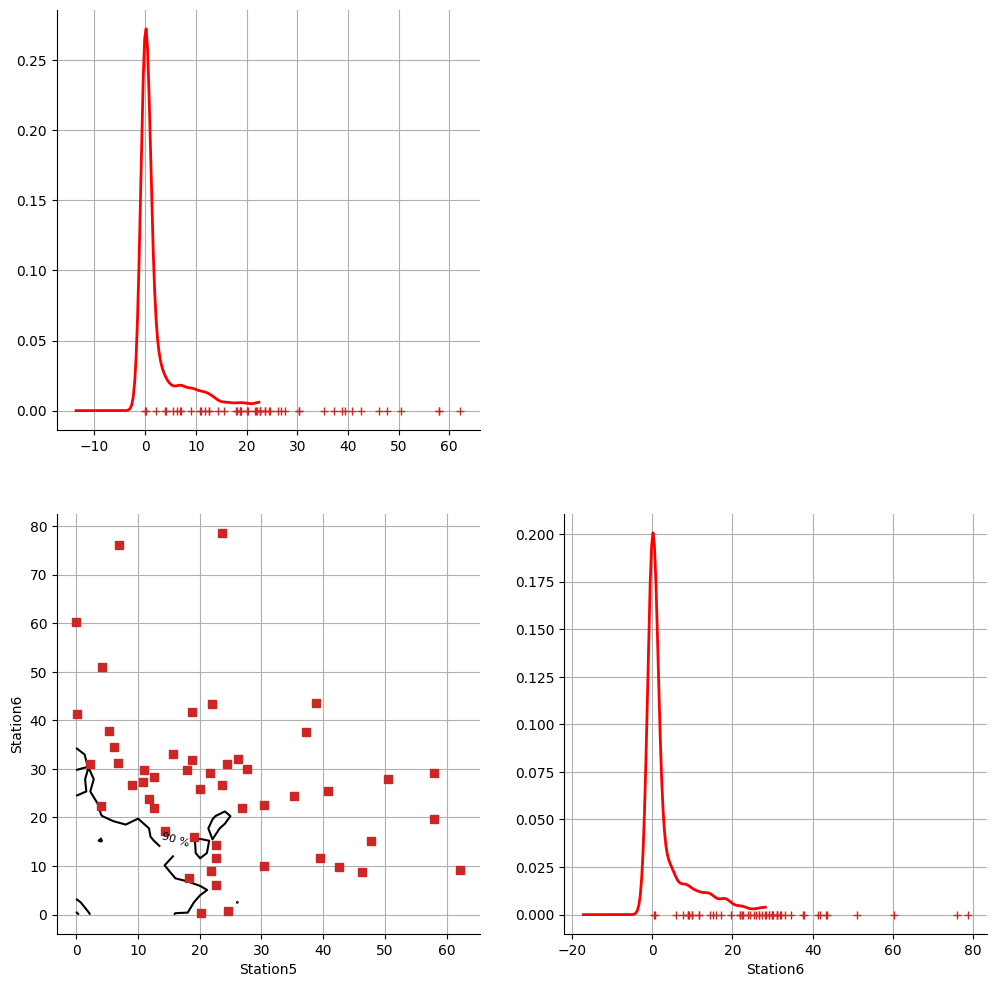

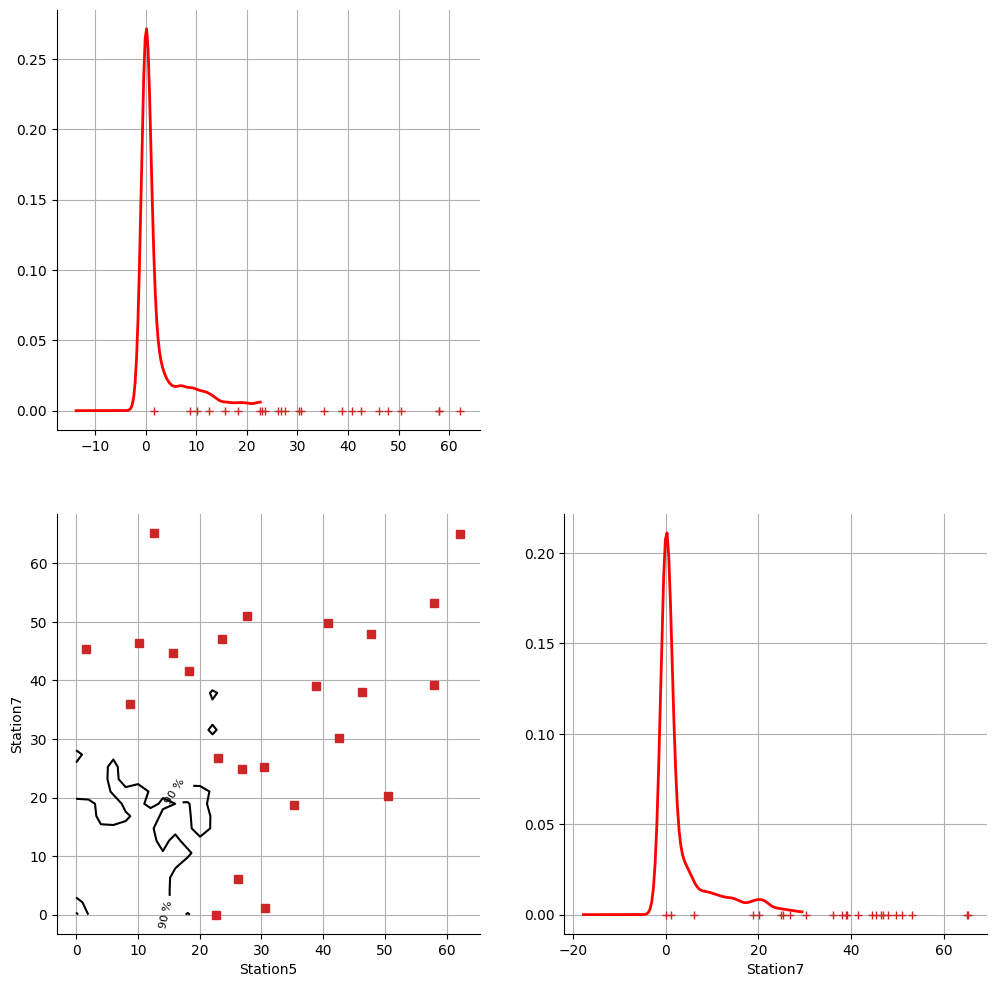

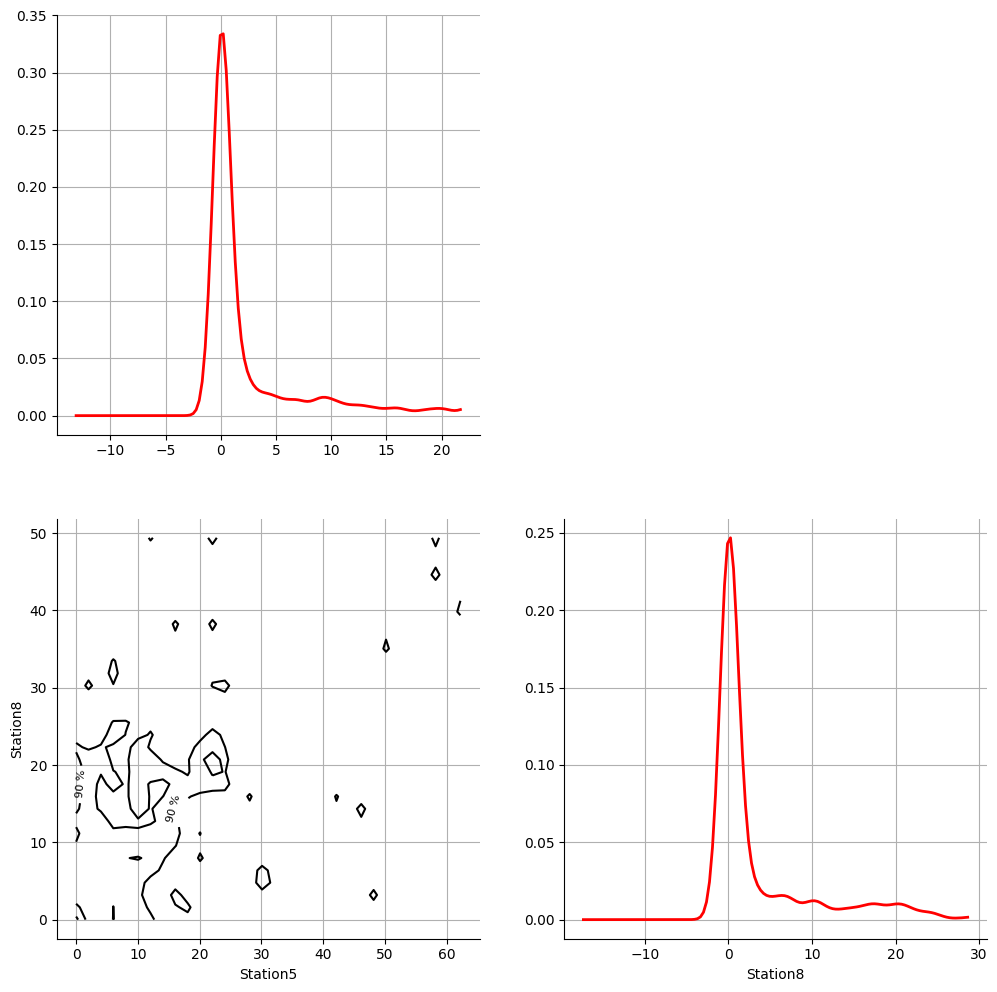

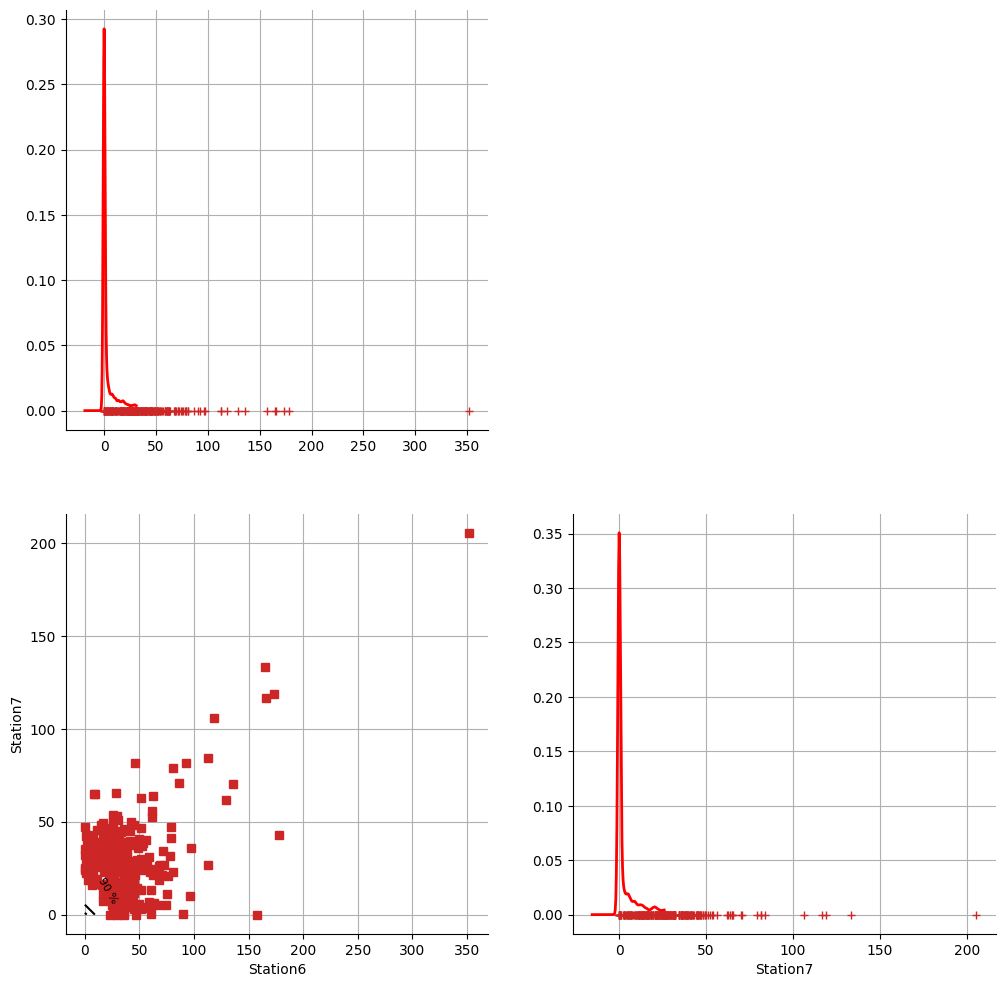

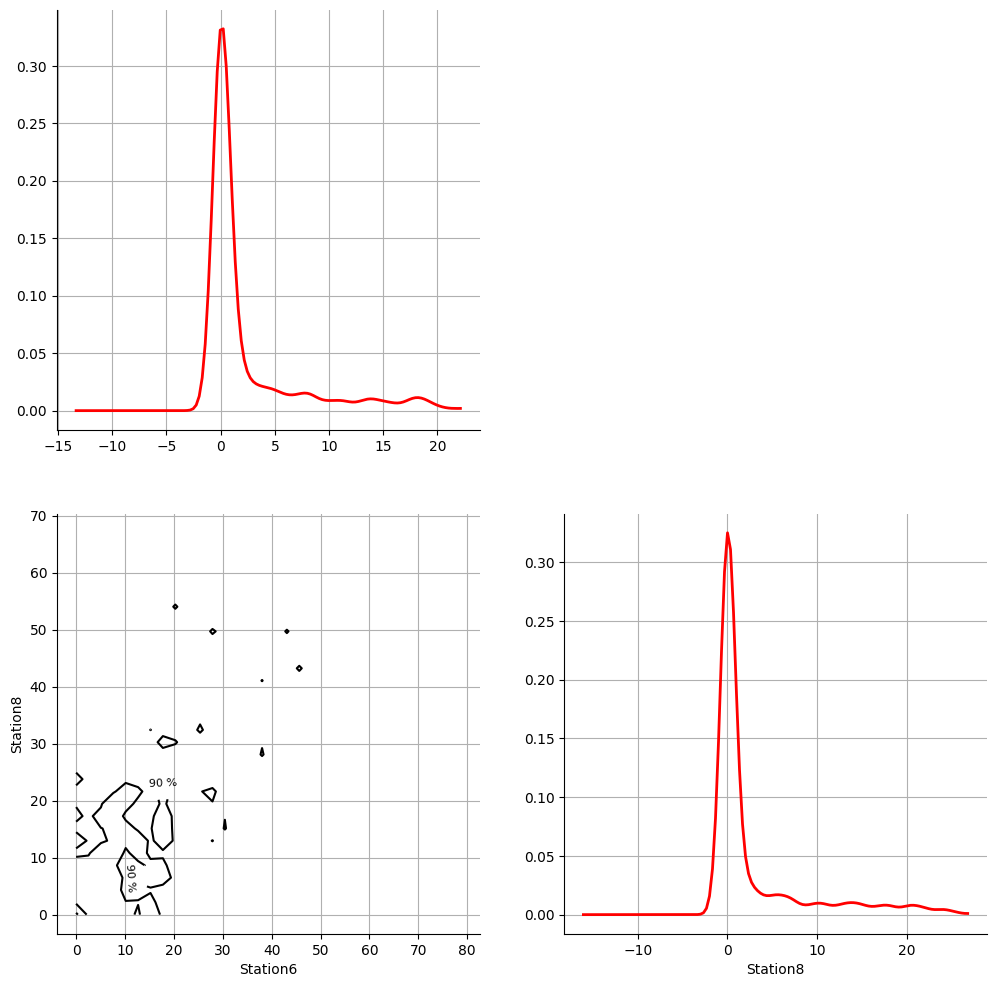

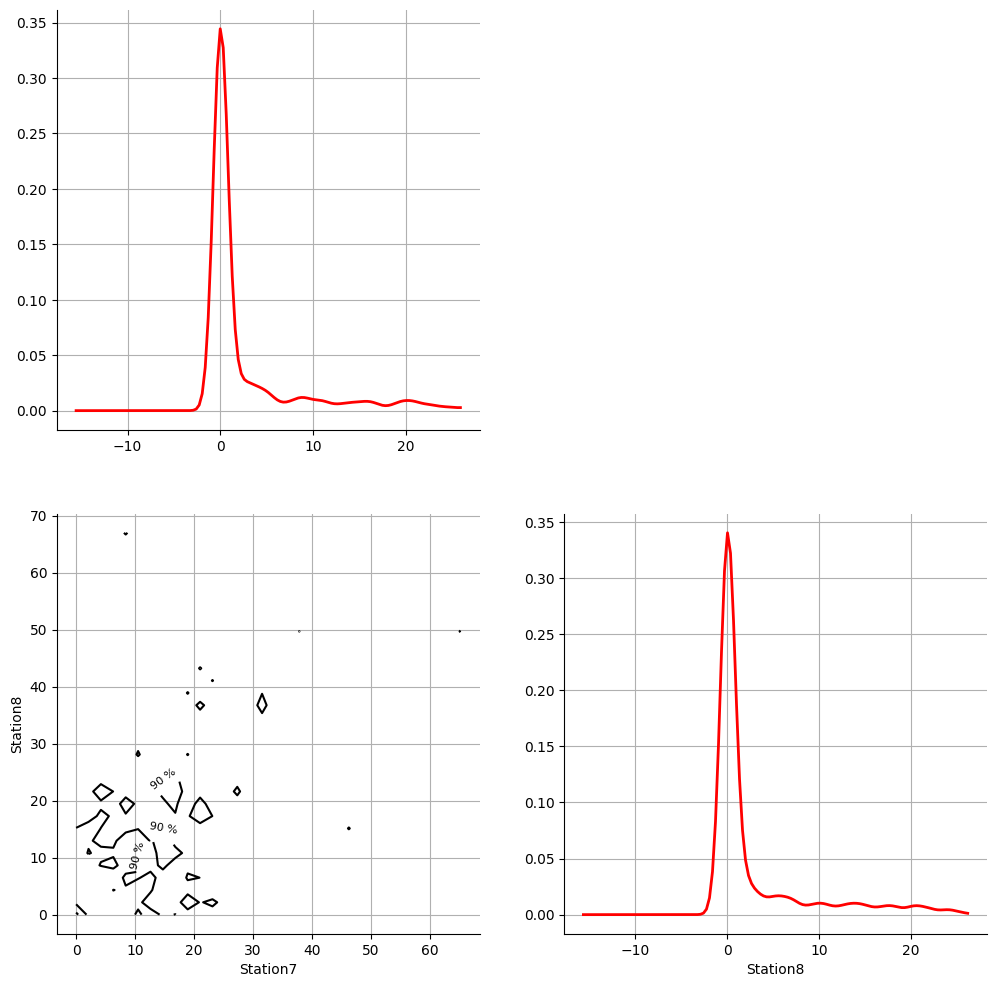

In [64]:
for es0 in stations:
    for es1 in stations:
        if es0[0] != es1[0]:
            filename = "{0}-{1}_hdrboxplot.png".format(es0[0], es1[0])
            filename2 = "{1}-{0}_hdrboxplot.png".format(es0[0], es1[0])
            
            if (os.path.exists(os.path.join(results_folder, filename)) or os.path.exists(os.path.join(results_folder, filename2))):
                continue
            date_min = es0[2] if es0[2] > es1[2] else es1[2]
            date_max = es0[3] if es0[3] < es1[3] else es1[3]
            #print("{0} --> {1} | Between {2} and {3}".format(es0[1], es1[1], date_min, date_max))

            filter = (df['StationId'].isin([es0[0], es1[0]])) & (df['DateTime'] >= date_min) & (df['DateTime'] <= date_max)
            df_filtered = df[filter].pivot(index='DateTime', columns='StationId')['IR']

            sample = ot.Sample.BuildFromDataFrame(df_filtered.dropna())
            myks = ot.KernelSmoothing()
            try:
                distribution = myks.build(sample)
                mydp = othdr.HighDensityRegionAlgorithm(sample, distribution)
                mydp.run()
            except Exception as error:
                print('Error in filename: ', filename, error)
                continue
            grid = mydp.draw()
            view = otv.View(grid)
            
            view.save(os.path.join(results_folder, filename))